In [1]:
import geopandas as gpd

In [2]:
street_segments = gpd.read_file("../data/processed/street_segments.geojson")
blocks = gpd.read_file("../data/processed/blocks.geojson")
buildings = gpd.read_file("../data/processed/buildings.geojson")
blockfaces = gpd.read_file("../data/processed/blockfaces.geojson")

## partition buildings across street segments into frontages

In [52]:
def filter_on_block_id(block_id, block_id_key="geoid10"):
    def select(df):
        return (df.set_index(block_id_key)
                    .filter(like=block_id, axis='rows')
                    .reset_index()
               )
    
    return select


model_block = blocks.iloc[0]
model_block_id = model_block.geoid10
model_blockfaces = blockfaces.pipe(filter_on_block_id(model_block_id))
model_street_segments = street_segments.pipe(filter_on_block_id(model_block_id))
model_buildings = buildings.pipe(filter_on_block_id(model_block_id))

In [340]:
def get_block_data(block_id):
    ss = street_segments.pipe(filter_on_block_id(block_id))
    bf = blockfaces.pipe(filter_on_block_id(block_id))
    bldgs = buildings.pipe(filter_on_block_id(block_id))
    return ss, bf, bldgs

In [341]:
def plot_block(block_id):
    street_segments, blockfaces, buildings = get_block_data(block_id)
    
    ax = street_segments.plot(color='red', linewidth=1)
    blockfaces.plot(color='black', ax=ax, linewidth=1)
    buildings.plot(ax=ax, color='lightsteelblue', linewidth=1, edgecolor='steelblue')
    return ax

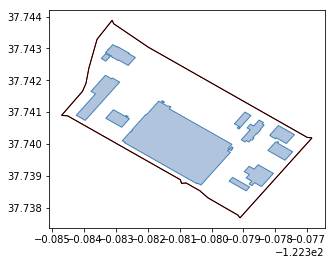

In [344]:
plot_block('060759809001134')

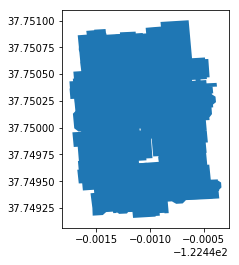

In [80]:
model_buildings.scale(xfact=3, yfact=3).plot()

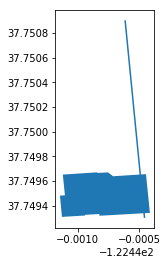

In [103]:
ax = model_street_segments.head(1).plot()
model_buildings.scale(xfact=3, yfact=3).head(1).plot(ax=ax)

In [112]:
mapping(
    model_street_segments.iloc[0].geometry.intersection(
        model_buildings.scale(xfact=3, yfact=3).iloc[0]
    )
)

{'type': 'LineString',
 'coordinates': ((-122.4404931517997, 37.74965236284071, 120.52999999999884),
  (-122.44046232737857, 37.74933879759523, 120.52999999999884))}

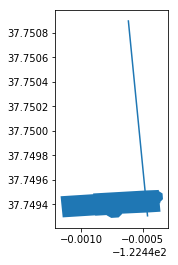

In [124]:
ax = gpd.GeoDataFrame([model_street_segments.iloc[0].drop('geometry')], 
                      geometry=[model_street_segments.iloc[0].geometry]).plot()
gpd.GeoSeries(model_buildings.scale(xfact=3, yfact=3).iloc[3]).plot(ax=ax)

In [126]:
model_overlapping_street_idx = 0
model_overlapping_building_idxs = (0, 3)

model_overlapping_street_segments = (
    model_street_segments.iloc[model_overlapping_street_idx].geometry.intersection(
        model_buildings.scale(xfact=3, yfact=3).iloc[model_overlapping_building_idxs[0]]
    ),
    model_street_segments.iloc[model_overlapping_street_idx].geometry.intersection(
        model_buildings.scale(xfact=3, yfact=3).iloc[model_overlapping_building_idxs[1]]
    )    
)

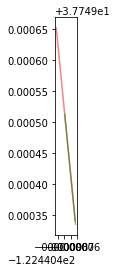

In [136]:
gpd.GeoSeries(model_overlapping_street_segments).plot(color=['red', 'green'], alpha=0.5)

In [138]:
model_overlapping_blockface_idx = 0
model_overlapping_building_idxs = (0, 3)

model_overlapping_blockface_frontages = (
    model_blockfaces.iloc[model_overlapping_blockface_idx].geometry.intersection(
        model_buildings.scale(xfact=3, yfact=3).iloc[model_overlapping_building_idxs[0]]
    ),
    model_blockfaces.iloc[model_overlapping_blockface_idx].geometry.intersection(
        model_buildings.scale(xfact=3, yfact=3).iloc[model_overlapping_building_idxs[1]]
    )    
)

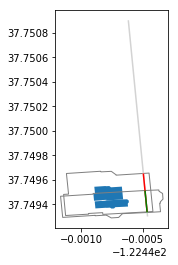

In [199]:
ax = gpd.GeoSeries(model_blockfaces.iloc[model_overlapping_blockface_idx]).plot(color='lightgray')
gpd.GeoSeries(model_overlapping_blockface_frontages).plot(color=['red', 'green'], ax=ax)
model_buildings.iloc[list(model_overlapping_building_idxs)].plot(ax=ax)
model_buildings.iloc[list(model_overlapping_building_idxs)].scale(xfact=3, yfact=3)\
    .plot(ax=ax, edgecolor='gray', linewidth=1, color='None')

Psuedocode for building blockface frontages:

```python
def frontages_for_blockface(bldgs, blockface):
    bldg_frontages = dict()

    # generate a list of frontages
    for bldg in buildings:
        bf_join = scale(bldg).intersection(bf)
        if bf_join:  # non-empty join
            bldg_frontages[bldg] = bf_join

    # make the frontages pairwise consistent
    for a, b in pairs(bldg_frontages):
        if a.intersects(b):
            a, b = make_consistent(a, b)

    # create empty frontages
    remaining_bf = blockface.difference({bldg_frontages})
    empty = subgeoms(remaining_bf)
    
    return join(bldg_frontages, empty)


def make_consistent(a, b):
    c = intersection(a, b)
    
    # pick a winner if intersection is full
    if a in c:
        return b
    elif b in c:
        return a
    
    # otherwise, split bipartite
    c_1, c2 = split_halfway(intersection)
    
    if c_1.touches(a):
        a = a.difference(c_2)
        b = b.difference(c_1)
    else:
        a = a.difference(c_1)
        b = b.difference(c_2)
        
    return a, b
```

In [330]:
import numpy as np

def make_consistent(a, b):
    def simplify(inp):
        inp = inp.convex_hull
        coords = np.round(mapping(inp)['coordinates'], decimals=4)
        out = LineString(coords)
        return out
    
    a, b = simplify(a), simplify(b)
    
    # TODO: do something smarter in the fully intersecting cases
    if a.contains(b):
        return a, None
    elif b.contains(a):
        return None, b
    
    c = a.intersection(b)
    if not c:
        return a, b

    import pdb; pdb.set_trace()
    c_midpoint = c.interpolate(0.5, normalized=True)
    c = c.union(c_midpoint)

    return

In [322]:
flattened_model_overlapping_blockface_frontages = (
    LineString([xy[0:2] for xy in list(model_overlapping_blockface_frontages[0].coords)]),
    LineString([xy[0:2] for xy in list(model_overlapping_blockface_frontages[1].coords)])    
)

In [328]:
gpd.GeoSeries(make_consistent(*flattened_model_overlapping_blockface_frontages))

0    LINESTRING (-122.4405 37.7497, -122.4405 37.7493)
1                                                 None
dtype: object

In [329]:
from shapely.geometry import MultiPolygon
from shapely.geometry import Polygon

def simplify_bldg(bldg):
    if isinstance(bldg, MultiPolygon):
        bldg = bldg.buffer(0)
    
    coords = [xyz[:2] for xyz in mapping(bldg.convex_hull)['coordinates'][0]]
    bldg = Polygon(bldg)
    
    return bldg

In [337]:
import itertools
list(itertools.combinations({'a': 12, 'b': 15, 'c': 13}.keys(), r=2))

[('a', 'b'), ('a', 'c'), ('b', 'c')]

In [338]:
def frontages_for_buildings(bldgs, blockfaces):
    bldg_frontages = dict()
    
    # generate a list of frontages
    for bldg in bldgs:
        bf_join = bldg.scale(xfact=3, yfact=3).intersection(blockfaces)
        if bf_join:  # non-empty join
            bldg_frontages[bldg] = bf_join

    # make the frontages pairwise consistent
    for a, b in list(itertools.combinations(bldg_frontages.keys(), r=2)):
        bldg_frontages[a], bldg_frontages[b] = make_consistent(bldg_frontages[a], bldg_frontages[b])

    # create empty frontages
    # remaining_bf = blockface.difference({bldg_frontages})
    # empty = subgeoms(remaining_bf)
    # return join(bldg_frontages, empty)    
    
    return bldg_frontages

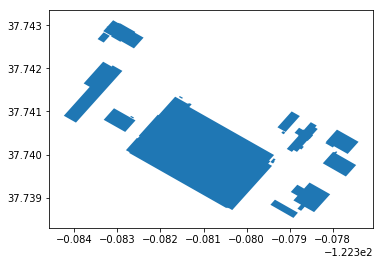

In [348]:
get_block_data('060759809001134')[2].scale(xfact=1, yfact=1).plot()

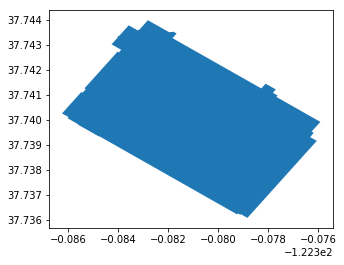

In [347]:
get_block_data('060759809001134')[2].scale(xfact=3, yfact=3).plot()

This is good evidence that this technique won't work anyway.

I'm going to abandon this approach and try a new one in a different notebook, carrying over any necessary methods to there.